## Import libraries

In [2]:
import skfuzzy as fuzz
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import seaborn as sns
import plotly.express as px
from numpy import searchsorted, array, real, where, shape, reshape, size
from numpy.fft import fft2, ifft2
from time import time
from bisect import bisect_right
import csv
from scipy.spatial.distance import cdist
from numpy.linalg import norm
from scipy.io import loadmat
from matplotlib.ticker import MaxNLocator
from matplotlib.colors import BoundaryNorm
import scipy.linalg as LA

# bigger font
font = {'family' : 'helvetica','size'   : 18}
plt.rc('font', **font) 

## Simulate double gyre

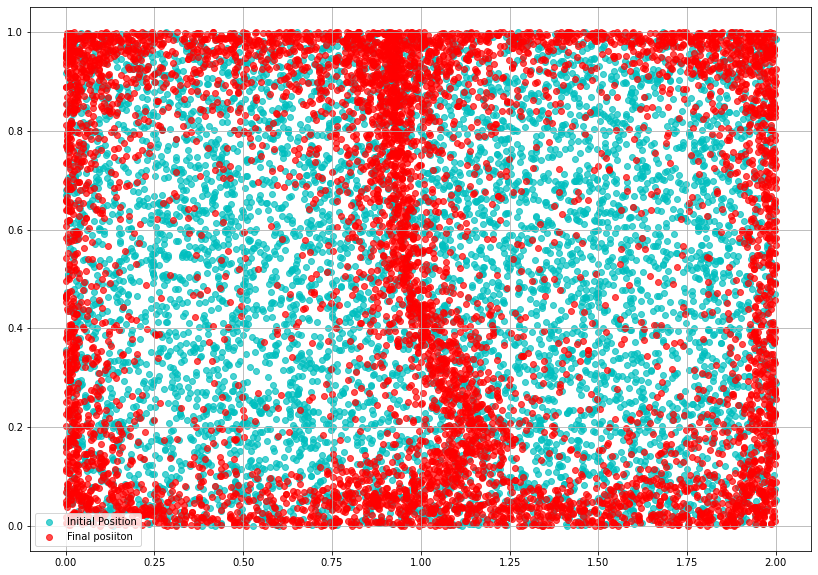

In [3]:
# constants
A = 0.25
epsilon = 0.25
w = np.pi*2 #/10

# horizontal comp.
def f(x,t):
    return epsilon*np.sin(w*t)*(x**2) + (1-2*epsilon*np.sin(w*t))*x

def u_gyre(x,y,t):
    return -np.pi*A*np.sin(np.pi*f(x,t))*np.cos(np.pi*y)

def v_gyre(x,y,t):
    return ((2*epsilon*np.sin(w*t)*x 
            + 1-2*epsilon*np.sin(w*t))*np.sin(np.pi*y)*np.pi*A*np.cos(np.pi*f(x,t)))

# function for random data init 

def rand_trace_double_gyre(M, final_t = 20, no_t_step = 201):

    # generate initial coords
    # draw in interval [0,1] to see it at work
    x0 = np.random.uniform(0,2,M)
    #x0 = (x0 - 0.5)*NX

    y0 = np.random.uniform(0,1,M)
    #y0 = (y0 - 0.5)*NY

    # time steps
    times, dt = np.linspace(0,final_t, no_t_step, retstep = True)

    # init arrays for point data
    x_pos = []
    y_pos = []

    # maybe add noise to this?

    # now reshape
    x = x0
    y = y0

    # save positions
    x_pos.append(x0)
    y_pos.append(y0)

    # loop through each time step
    for t in times:
        x1 = x + u_gyre(x,y,t)*dt
        y1 = y + v_gyre(x,y,t)*dt

        # save positions
        x_pos.append(x1)
        y_pos.append(y1)

        y = np.copy(y1)
        x = np.copy(x1)
        
    return x_pos, y_pos, dt

# number of data points 
M = 55**2
# M = 23**2
M = 80**2

# end time
final_time = 10

x_pos, y_pos, dt = rand_trace_double_gyre(M, final_time)
    
# plotting
plt.figure(figsize=(14,10))
plt.scatter(x_pos[0], y_pos[0], color='c', 
            label = 'Initial Position', 
            alpha = 0.7)
plt.scatter(x_pos[-1], y_pos[-1], color='r', 
            label = 'Final posiiton',
            alpha = 0.7)
plt.legend()
plt.grid()
plt.show()

## Helper functions

In [5]:
# plotting different liklihood values
def plot_cluster_likelihoods(x, y, u, fig_dim = (12,12)):
    
    #fig, axes = plt.subplots(u.shape[0], 1, sharex=True, figsize=(16,10))
    
    print(f'\nThe likelihood plots for {u.shape[1]} clusters are as follows: \n')
    
    # create bins
    bins = np.linspace(0,1,11)
    
    # loop through each cluster
    for i in range(u.shape[1]):
        
        # extract cluster likelihood
        cluster_u = u[:,i]
        
        # bin u values
        u_binned = np.digitize(cluster_u, bins)

        # plotting
        plt.figure(figsize=fig_dim)

        sns.scatterplot(x=x_dat,
                        y=y_dat,
                        hue=u_binned,
                        palette='plasma',
                        alpha=0.7,
                        legend='full')

        plt.title(f'Cluster {i+1} membership likelihood values')
        plt.legend(np.round(bins[1:],1), title='Likelihood Value')
        plt.xlabel('x')
        plt.ylabel('y')
        plt.grid()
        plt.tight_layout()
    plt.show()
    
    print('-------------------------------------------------------------------------------------------------\n')
    
def bilinear_interp_periodic(x_1d, y_1d, zz, x_wanted, y_wanted):
    '''
    Hossein's interpolation function:
    x_1d, y_1d (1darray): row and columns respectively of regularly spaced grid - each is a 1d array
    zz (2d array): values to be interpolated
    x_wanted, y_wanted: array of particle positions we want to interpolate
    '''
    init_shape = shape(x_wanted)
    x_wanted = x_wanted.flatten()
    y_wanted = y_wanted.flatten()
    z_wanted = np.zeros_like(x_wanted)

#     x_max = np.max(x_1d)
#     x_min = np.min(x_1d)
#     y_max = np.max(y_1d)
#     y_min = np.min(y_1d)

#     x_interval = x_max - x_min
#     y_interval = y_max - y_min

    for i_xy in range(0, size(x_wanted)):
        x = x_wanted[i_xy]
        y = y_wanted[i_xy]

        # this might be redundant and actually causing errors in the general case?
        # x = x - np.floor(x/x_interval)*(x_interval)
        # y = y - np.floor(y/(y_interval))*(y_interval)

#         i_2x = searchsorted(x_1d, x)
#         i_2y = searchsorted(y_1d, y)

        i_2x = bisect_right(x_1d, x)
        i_2y = bisect_right(y_1d, y)
        i_1x = i_2x - 1
        i_1y = i_2y - 1
        
        #print(i_2x, i_2y)

        FF = array([[zz[i_1y, i_1x], zz[i_2y, i_1x]],
                       [zz[i_1y, i_2x], zz[i_2y, i_2x]]])
        z_wanted[i_xy] = 1/((x_1d[i_2x]-x_1d[i_1x])*(y_1d[i_2y]-y_1d[i_1y]))*(
            array([x_1d[i_2x] - x, x - x_1d[i_1x]])@FF@
            array([[y_1d[i_2y] - y], [y - y_1d[i_1y]]]))

    return reshape(z_wanted, init_shape)

def domain_check2(x,y, x_grid, y_grid):
    '''
    Function to get particle position in 'original' domain
    faster and assumes that we do not get more than 1 domain length away from the domain in 1 timestep
    '''

    # get max and min values
    x_max = x_grid[-1]
    x_min = x_grid[0]
    y_max = y_grid[-1]
    y_min = y_grid[0]

    # intervals
    x_int = x_max - x_min
    y_int = y_max - y_min

    # get x coords in original domain
    new_x = where(x >= x_max, x - x_int, x)
    new_x = where(new_x < x_min, new_x + x_int, new_x)

    # get y coords in original domain
    new_y = where(y >= y_max, y - y_int, y)
    new_y = where(new_y < y_min, new_y + y_int, new_y)

    return new_x, new_y

## Loading Trajectories

In [9]:
# loading and testing 
x_pos = np.load('./ShallowWater/eddie_results_store/eddie_files_result4/x_trajs.npy')
y_pos = np.load('./ShallowWater/eddie_results_store/eddie_files_result4/y_trajs.npy')

# h_result = np.load('./ShallowWater/eddie_results_store/eddie_files_result4/h_fields.npy')
# u_result = np.load('./ShallowWater/eddie_results_store/eddie_files_result4/u_fields.npy')
# v_result = np.load('./ShallowWater/eddie_results_store/eddie_files_result4/v_fields.npy')

# omitting some results for speed
skip = 40

x_pos = np.copy(x_pos[::skip, :, :])
y_pos = np.copy(y_pos[::skip, :, :])

dt = 0.005
final_time = 600

In [10]:
x_pos.shape

(600, 64, 64)

## loading turbulence - fast waves

(128, 128)
(128, 128, 601)


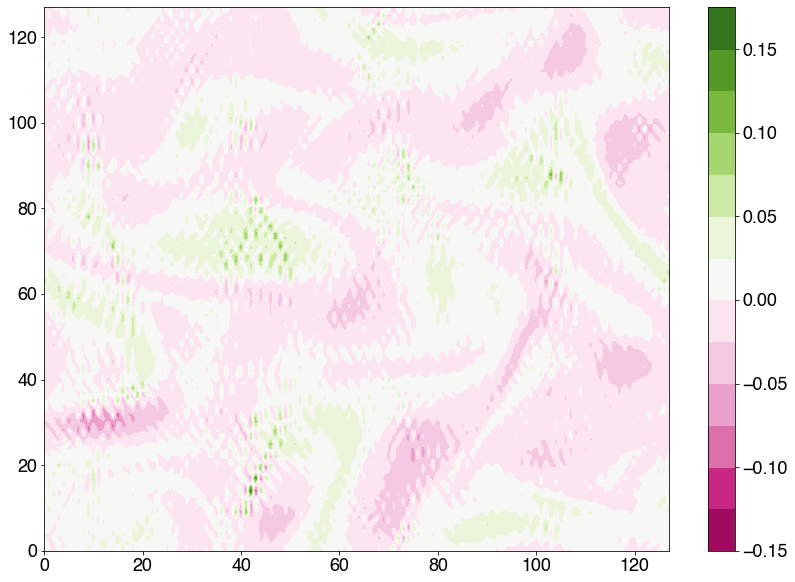

In [6]:
uvSW = loadmat('uv_SWturb_ki2_fastwaves_alt.mat')
uu = uvSW['u_all']
vv = uvSW['v_all']

# Time step
Tend = 240

final_time = Tend

# Note: kw = 7 (wave number)

Nx = 128
Ny = 128
dx = 2*np.pi/Nx
dy = 2*np.pi/Ny
# iTime = 600

iTime = uu.shape[-1] - 1

u_S = np.concatenate((uu[-1:Ny, :, iTime], uu[0:-1, :, iTime]), axis=0)
u_N = np.concatenate((uu[1:, :, iTime], uu[0:1, :, iTime]), axis=0)
v_W = np.concatenate((vv[:, -1:Nx, iTime], vv[:, 0:-1, iTime]), axis=1)
v_E = np.concatenate((vv[:, 1:, iTime], vv[:, 0:1, iTime]), axis=1)

zr = (v_E-v_W)/(2*dy)-(u_N-u_S)/(2*dy)

print(np.shape(u_S))
print(np.shape(uu))

cmap = plt.get_cmap('PiYG')
levels = MaxNLocator(nbins=15).tick_values(zr.min(), zr.max())
norm = BoundaryNorm(levels, ncolors=cmap.N, clip=True)

fig = plt.figure(figsize = (14,10))
ax = plt.axes()
# im = ax.pcolormesh(zr, cmap=cmap, norm=norm)
cf = ax.contourf(zr, levels=levels, cmap=cmap)
fig.colorbar(cf, ax=ax)

plt.show()

(128, 128)
(128, 128, 601)


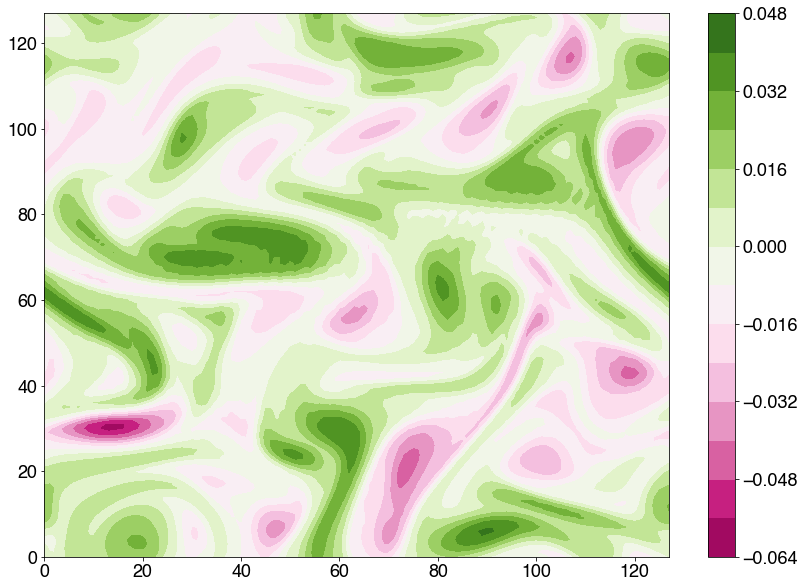

In [155]:
uvSW = loadmat('uv_SWturb_ki2_nowaves.mat')
uu = uvSW['u_all']
vv = uvSW['v_all']

# Time step
Tend = 240

final_time = Tend

# Note: kw = 7 (wave number)

Nx = 128
Ny = 128
dx = 2*np.pi/Nx
dy = 2*np.pi/Ny
# iTime = 600

iTime = uu.shape[-1] - 1

u_S = np.concatenate((uu[-1:Ny, :, iTime], uu[0:-1, :, iTime]), axis=0)
u_N = np.concatenate((uu[1:, :, iTime], uu[0:1, :, iTime]), axis=0)
v_W = np.concatenate((vv[:, -1:Nx, iTime], vv[:, 0:-1, iTime]), axis=1)
v_E = np.concatenate((vv[:, 1:, iTime], vv[:, 0:1, iTime]), axis=1)

zr = (v_E-v_W)/(2*dy)-(u_N-u_S)/(2*dy)

print(np.shape(u_S))
print(np.shape(uu))

cmap = plt.get_cmap('PiYG')
levels = MaxNLocator(nbins=15).tick_values(zr.min(), zr.max())
norm = BoundaryNorm(levels, ncolors=cmap.N, clip=True)

fig = plt.figure(figsize = (14,10))
ax = plt.axes()
# im = ax.pcolormesh(zr, cmap=cmap, norm=norm)
cf = ax.contourf(zr, levels=levels, cmap=cmap)
fig.colorbar(cf, ax=ax)

plt.show()

(128, 128)
(128, 128, 601)


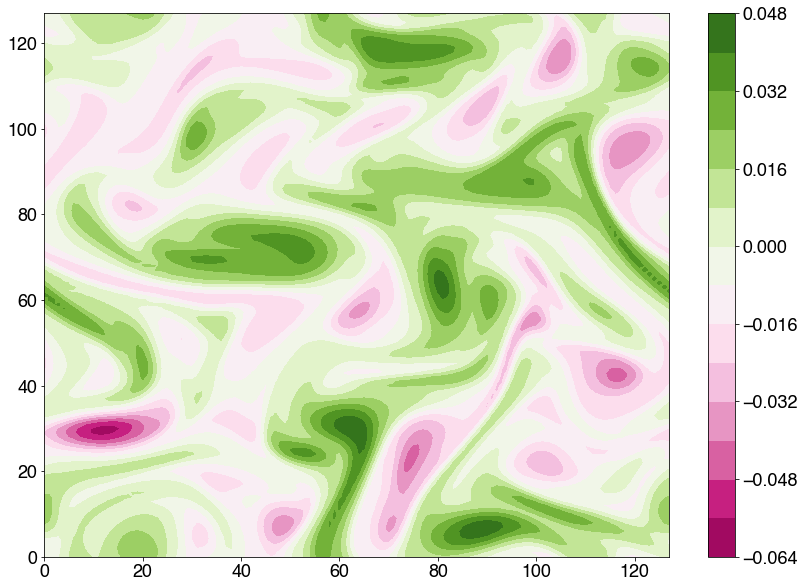

In [29]:
uvSW = loadmat('uv_SWturb_ki2_slowwaves_alt.mat')
uu = uvSW['u_all']
vv = uvSW['v_all']

# Time step
Tend = 240

final_time = Tend

# Note: kw = 7 (wave number)

Nx = 128
Ny = 128
dx = 2*np.pi/Nx
dy = 2*np.pi/Ny
# iTime = 600

iTime = uu.shape[-1] - 1

u_S = np.concatenate((uu[-1:Ny, :, iTime], uu[0:-1, :, iTime]), axis=0)
u_N = np.concatenate((uu[1:, :, iTime], uu[0:1, :, iTime]), axis=0)
v_W = np.concatenate((vv[:, -1:Nx, iTime], vv[:, 0:-1, iTime]), axis=1)
v_E = np.concatenate((vv[:, 1:, iTime], vv[:, 0:1, iTime]), axis=1)

zr = (v_E-v_W)/(2*dy)-(u_N-u_S)/(2*dy)

print(np.shape(u_S))
print(np.shape(uu))

cmap = plt.get_cmap('PiYG')
levels = MaxNLocator(nbins=15).tick_values(zr.min(), zr.max())
norm = BoundaryNorm(levels, ncolors=cmap.N, clip=True)

fig = plt.figure(figsize = (14,10))
ax = plt.axes()
# im = ax.pcolormesh(zr, cmap=cmap, norm=norm)
cf = ax.contourf(zr, levels=levels, cmap=cmap)
fig.colorbar(cf, ax=ax)

plt.show()

In [30]:
# Nx = 128
# Ny = 128

Nx = 64
Ny = 64

# define domain boundaries
x_start = 0
x_end = 2*np.pi
y_start = 0
y_end = 2*np.pi

res = 5
no_skip = 2

# timestep
dt = 0.04 * (res*no_skip)

# create x and y spacing
x = np.linspace(0, 2*np.pi, Nx)
y = np.linspace(0, 2*np.pi, Ny)


# create particle grid
x_grid, y_grid = np.meshgrid(x, y)

# copy grid position for initial position
x_pos, y_pos = np.copy(x_grid), np.copy(y_grid)

# add trajectory to list and start list
x_traj = [np.copy(x_pos)]
y_traj = [np.copy(y_pos)]

# loop through each velocity field
for i in range(uu.shape[-1]):
    
    # check all points are in domain
    x_in_domain, y_in_domain = domain_check2(x_pos, y_pos, x, y)
    
    # run twice for redundancy
    x_pos_in_domain_check, y_pos_in_domain_check = domain_check2(x_in_domain, y_in_domain, x, y)
    
    # check that particles are in domain
    while np.all(x_pos_in_domain_check == x_in_domain) != True or np.all(y_pos_in_domain_check == y_in_domain) != True:
        x_pos_in_domain_check, y_pos_in_domain_check = np.copy(x_in_domain), np.copy(y_in_domain)
        x_in_domain, y_in_domain = domain_check2(x_pos_in_domain_check, x_pos_in_domain_check, x, y)
    
    # interpolate velocity values and update x_pos, y_pos
    x_pos += dt*bilinear_interp_periodic(x, y, uu[:,:,i], x_in_domain, y_in_domain)
    y_pos += dt*bilinear_interp_periodic(x, y, vv[:,:,i], x_in_domain, y_in_domain)
    
#     if i % 100 == 0:
#         plt.figure(figsize=(14,10))
#         plt.scatter(x_pos.flatten(), y_pos.flatten(),
#                     alpha = 0.75)
#         plt.grid()
#         plt.show()
    
    x_traj.append(np.copy(x_pos))
    y_traj.append(np.copy(y_pos))

In [31]:
dt_pre = np.copy(dt)

In [32]:
skip = 1

new_dt = dt_pre*skip

x_pos, y_pos = np.array(x_traj[::skip]), np.array(y_traj[::skip])

x_pos.shape

(602, 64, 64)

In [201]:
# # discard every other position:
# x_pos_new = []
# y_pos_new = []

# for i in range(x_pos.shape[0]):
    
#     # flatten and discard every 4th trajectory
#     x_hold = np.copy(x_pos[i].flatten())[::4]
#     y_hold = np.copy(y_pos[i].flatten())[::4]
    
#     # reshape
#     x_hold = np.reshape(x_hold, (64,64))
#     y_hold = np.reshape(y_hold, (64,64))
    
#     # add to lists
#     x_pos_new.append(x_hold)
#     y_pos_new.append(y_hold)

# # make array
# x_pos = np.array(x_pos_new)
# y_pos = np.array(y_pos_new)

In [227]:
x_pos.shape

(64, 64)

In [203]:
x_pos = np.array(x_pos_new)
y_pos = np.array(y_pos_new)

x_pos.shape

(201, 64, 64)

## Spectral Clustering

In [33]:
# constructing similarity matrix 

m = x_pos.shape[0]

no_particles = x_pos[0].flatten().shape[0]

# dist_mat = np.zeros((x_pos[0].shape[0], x_pos[0].shape[0]))

dist_mat = np.zeros((no_particles, no_particles))

# loop through time steps
for i in range(m):
    
    inner_start = time()
    
    # retrieve coordinates for time step
    x = x_pos[i].flatten()
    y = y_pos[i].flatten()
    
#     coords = []
    
#     # create coordinate tuples
#     for j in range(len(x)):
#         coords.append((x[j], y[j]))
                    
    coords = np.column_stack((x,y))
    
    # calculate distance matrix
    holder_dist_mat = cdist(coords, coords)
                    
    #holder_dist_mat = norm(coords[:, None, :] - coords[None, :,  :], axis=2)
    
#     # first and last timestep only included once
#     if i == 0 or i == (len(x) - 1):
#         dist_mat = dist_mat + holder_dist_mat
#     else:
#         dist_mat = dist_mat + 2*holder_dist_mat

    # faster without if statements
    dist_mat += 2*holder_dist_mat
    
    inner_end = time()
    
    print(f'Loop {i}: {inner_end-inner_start}')


# remove first and last dist_mat value
correction = [0, -1]

for i in correction:
        
    x = x_pos[i].flatten()
    y = y_pos[i].flatten()
    
    coords = np.column_stack((x,y))
    holder_dist_mat = cdist(coords, coords)
                    
    dist_mat -= holder_dist_mat

# summation constant adjustment
dist_mat = (dt/2 * (m-1)) * 1/(final_time) * dist_mat

# make diagonals 1 
dist_mat += np.eye(x_pos[0].flatten().shape[0])


Loop 0: 0.2933340072631836
Loop 1: 0.1343538761138916
Loop 2: 0.1261310577392578
Loop 3: 0.12429213523864746
Loop 4: 0.12292718887329102
Loop 5: 0.14120101928710938
Loop 6: 0.12846803665161133
Loop 7: 0.12656807899475098
Loop 8: 0.1294419765472412
Loop 9: 0.13383221626281738
Loop 10: 0.129288911819458
Loop 11: 0.13302874565124512
Loop 12: 0.1338958740234375
Loop 13: 0.14057540893554688
Loop 14: 0.13230204582214355
Loop 15: 0.1419358253479004
Loop 16: 0.17207002639770508
Loop 17: 0.14121699333190918
Loop 18: 0.16076898574829102
Loop 19: 0.1548140048980713
Loop 20: 0.12914299964904785
Loop 21: 0.12807774543762207
Loop 22: 0.12079811096191406
Loop 23: 0.12276816368103027
Loop 24: 0.12136077880859375
Loop 25: 0.1273031234741211
Loop 26: 0.12241315841674805
Loop 27: 0.11944913864135742
Loop 28: 0.11829185485839844
Loop 29: 0.11856317520141602
Loop 30: 0.11907410621643066
Loop 31: 0.11894106864929199
Loop 32: 0.12293720245361328
Loop 33: 0.11966609954833984
Loop 34: 0.12069416046142578
Loop 

Loop 279: 0.1183919906616211
Loop 280: 0.12000679969787598
Loop 281: 0.12125205993652344
Loop 282: 0.11916208267211914
Loop 283: 0.12194466590881348
Loop 284: 0.12445712089538574
Loop 285: 0.14416098594665527
Loop 286: 0.15568804740905762
Loop 287: 0.12879180908203125
Loop 288: 0.12111806869506836
Loop 289: 0.12028002738952637
Loop 290: 0.11897802352905273
Loop 291: 0.11930298805236816
Loop 292: 0.12410902976989746
Loop 293: 0.15279102325439453
Loop 294: 0.11590313911437988
Loop 295: 0.12429308891296387
Loop 296: 0.1229548454284668
Loop 297: 0.14061284065246582
Loop 298: 0.1340169906616211
Loop 299: 0.1449129581451416
Loop 300: 0.13095402717590332
Loop 301: 0.13511013984680176
Loop 302: 0.1573469638824463
Loop 303: 0.19444775581359863
Loop 304: 0.1507711410522461
Loop 305: 0.14501309394836426
Loop 306: 0.13377904891967773
Loop 307: 0.1464073657989502
Loop 308: 0.14938783645629883
Loop 309: 0.1437218189239502
Loop 310: 0.13202571868896484
Loop 311: 0.14139103889465332
Loop 312: 0.157377

Loop 555: 0.11920785903930664
Loop 556: 0.11998486518859863
Loop 557: 0.11708760261535645
Loop 558: 0.11762189865112305
Loop 559: 0.11988687515258789
Loop 560: 0.13884496688842773
Loop 561: 0.11457395553588867
Loop 562: 0.11670279502868652
Loop 563: 0.11748695373535156
Loop 564: 0.12083196640014648
Loop 565: 0.11644911766052246
Loop 566: 0.1197969913482666
Loop 567: 0.11840510368347168
Loop 568: 0.11562705039978027
Loop 569: 0.11424708366394043
Loop 570: 0.1180262565612793
Loop 571: 0.1180882453918457
Loop 572: 0.11793994903564453
Loop 573: 0.11833000183105469
Loop 574: 0.11595296859741211
Loop 575: 0.12538480758666992
Loop 576: 0.1242818832397461
Loop 577: 0.125823974609375
Loop 578: 0.12320995330810547
Loop 579: 0.12412500381469727
Loop 580: 0.12393999099731445
Loop 581: 0.12672996520996094
Loop 582: 0.12423229217529297
Loop 583: 0.12561321258544922
Loop 584: 0.1229398250579834
Loop 585: 0.12288904190063477
Loop 586: 0.12060403823852539
Loop 587: 0.12416601181030273
Loop 588: 0.12479

In [34]:
final_time = 240

# summation constant adjustment
dist_mat = (new_dt/2 * (m-1)) * 1/(final_time) * dist_mat

# make diagonals 1 
dist_mat += np.eye(x_pos[0].flatten().shape[0])

## load and save dist_mat

In [23]:
# dist_mat.shape
# x_pos.shape

# np.save('result4_param_free_dist_mat_skip4.npy', dist_mat)

# np.save('fastwave_turb_shortened_distmat.npy', dist_mat)

In [12]:
# dist_mat = np.load('result4_param_free_dist_mat_skip4.npy')
# dist_mat = np.load('fastwave_turb_shortened_distmat.npy')

In [35]:
dist_mat.shape

(4096, 4096)

Time taken: 41.09903311729431
Time taken: 35.85227108001709
Time taken: 37.63391184806824
Time taken: 36.417696952819824
Time taken: 39.36421298980713
Time taken: 38.76169204711914
Time taken: 37.62269330024719
Time taken: 36.02006697654724
Time taken: 40.52643823623657
Time taken: 48.60390877723694
Time taken: 39.910094261169434
Time taken: 44.450109004974365
Time taken: 37.60728073120117
Time taken: 44.00670790672302
Time taken: 45.959391832351685
Time taken: 41.547203063964844
Time taken: 42.704856157302856
Time taken: 51.915278911590576
Time taken: 46.72001791000366
Time taken: 48.17305088043213


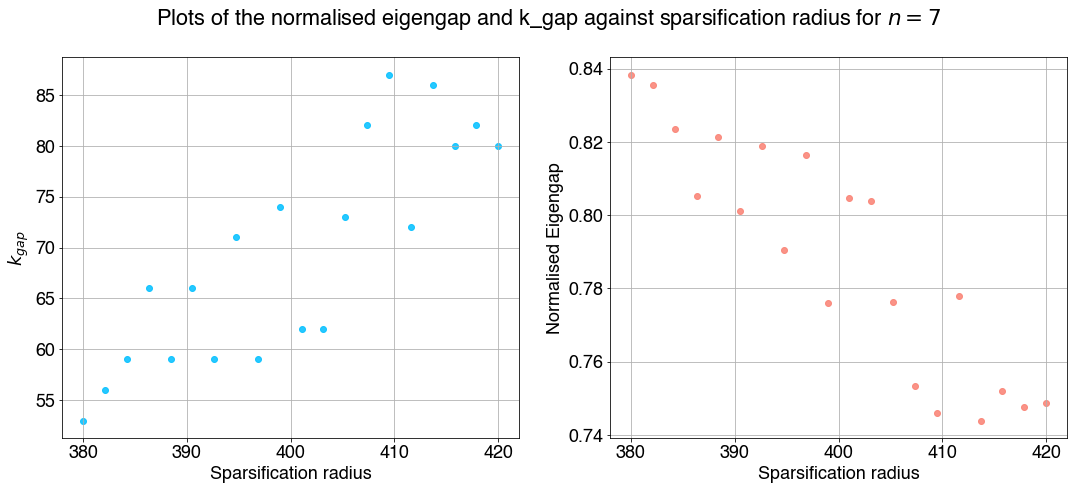

In [290]:
from time import time

# list of n to loop through
n_list = [7]

# r_list = np.linspace(10, 120, 20)

# r_list = np.linspace(280, 310, 15)

r_list = np.linspace(380, 420, 20)

dominant_val = 40

# loop through n
for n in n_list:

    # init lists
    k_gap_list = []
    eigengap_list = []
    
    # loop through sparsification
    for sparsification_radius in r_list:
        
        start = time()

        W = 1/dist_mat

        # setting diagonal value - was before
        #W += np.eye(W.shape[0]) * np.max(W) * (10**n)

        # remove all similarities below threshold - sparsify
        W = np.where(W <= 1/sparsification_radius, 0, W)
        
        W += np.eye(W.shape[0]) * np.max(W) * (10**n)

        # create degree matrix
        D = np.diagflat(np.sum(W, axis=1))

        # calc. laplacian matrix
        L = D - W

        # calculate D**(-0.5)
        D_half = np.diagflat(np.sum(W, axis=1)**(-0.5))

        # normalized graph laplacian
        L = D_half @ L @ D_half

        # calculate eigenvectors and vals
        vals, vecs = np.linalg.eig(L)

        # if eig does not converge it returns 0 eigenvalues so return 0 and go to next loop
        if np.all(vals == np.zeros_like(vals)) == True or np.any(vals) == False:
            k_gap_list.append(0)
            eigengap_list.append(0)

            continue
        
        # calculate maximum eigengap - was an abs here at the beginning
        max_eigengap = np.max(np.diff(vals))

        # get k_gap
        k_gap = np.where(np.diff(vals) == max_eigengap)[0][0]
        
        # add k_gap to list
        k_gap_list.append(k_gap)

        # calc. normalised eigengap
        norm_eigengap = max_eigengap / (max(vals) - min(vals))
        
        # add eigengap to list
        eigengap_list.append(norm_eigengap)
        
        end = time()
        
        print(f'Time taken: {end-start}')
              
    # plotting results
    plt.figure(figsize=(18,7))

    plt.suptitle(f'Plots of the normalised eigengap and k_gap against sparsification radius for $n = {n}$')

    plt.subplot(1,2,1)
    plt.scatter(r_list, k_gap_list, c='deepskyblue', alpha = 0.85)
    plt.xlabel('Sparsification radius')
    plt.ylabel('$k_{gap}$')
    plt.grid()

    plt.subplot(1,2,2)
    plt.scatter(r_list, eigengap_list, c='salmon', alpha = 0.85)
    plt.xlabel('Sparsification radius')
    plt.ylabel('Normalised Eigengap')
    plt.grid()
    plt.show()

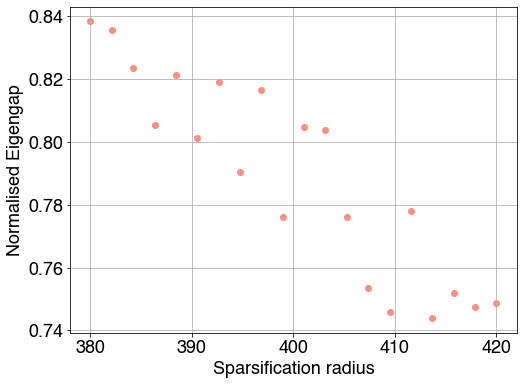

In [291]:
plt.figure(figsize=(8,6))
plt.scatter(r_list, eigengap_list, c='salmon', alpha = 0.85)
plt.xlabel('Sparsification radius')
plt.ylabel('Normalised Eigengap')
plt.grid()
plt.show()

In [209]:
r_list

array([ 10.        ,  15.78947368,  21.57894737,  27.36842105,
        33.15789474,  38.94736842,  44.73684211,  50.52631579,
        56.31578947,  62.10526316,  67.89473684,  73.68421053,
        79.47368421,  85.26315789,  91.05263158,  96.84210526,
       102.63157895, 108.42105263, 114.21052632, 120.        ])

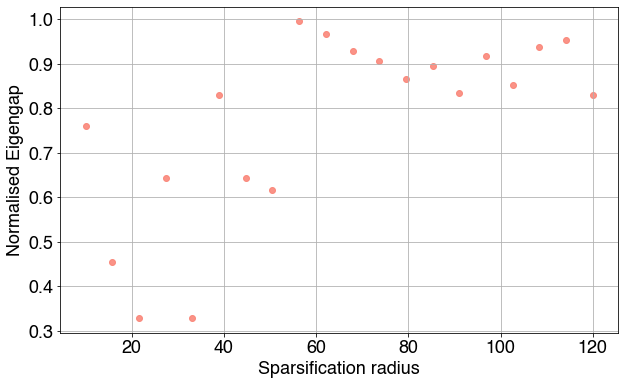

In [111]:
plt.figure(figsize=(10,6))
plt.scatter(r_list, eigengap_list, c='salmon', alpha = 0.85)
plt.xlabel('Sparsification radius')
plt.ylabel('Normalised Eigengap')
plt.grid()
plt.show()

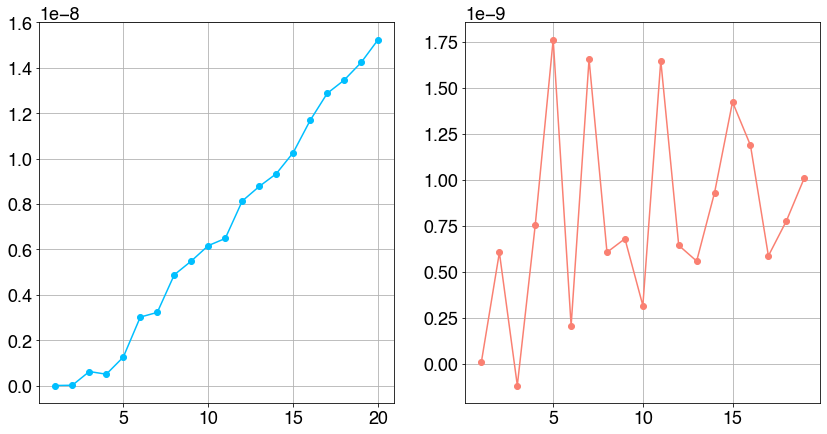

In [82]:
vals_plot = vals[:20]

plt.figure(figsize=(14,7))
plt.subplot(121)
plt.plot((np.arange(len(vals_plot)) + 1), vals_plot, '-o', c='deepskyblue')
plt.grid()

plt.subplot(122)
plt.plot((np.arange(len(vals_plot)) + 1)[:-1], np.diff(vals_plot), '-o', c='salmon')
plt.grid()
plt.show()

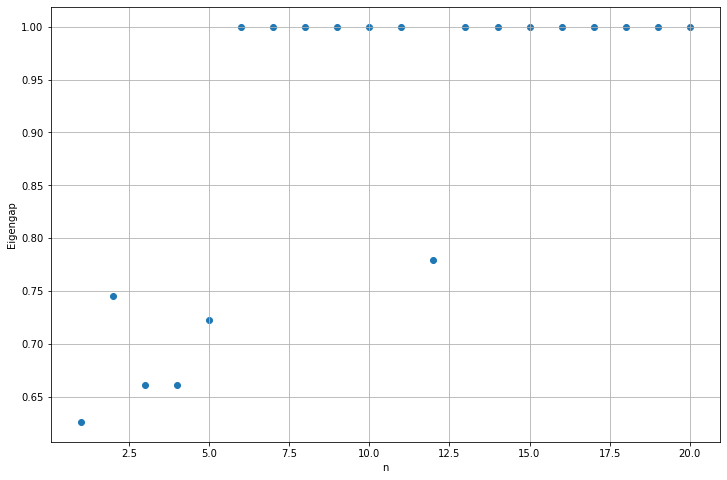

In [29]:
index = np.arange(end_n) + 1

plt.figure(figsize=(12,8))
plt.scatter(index, eigengap_list)
plt.xlabel('n')
plt.ylabel('Eigengap')
plt.grid()
plt.show()

In [151]:
r_list

array([ 10.        ,  15.78947368,  21.57894737,  27.36842105,
        33.15789474,  38.94736842,  44.73684211,  50.52631579,
        56.31578947,  62.10526316,  67.89473684,  73.68421053,
        79.47368421,  85.26315789,  91.05263158,  96.84210526,
       102.63157895, 108.42105263, 114.21052632, 120.        ])

In [36]:
n=7

W = 1/dist_mat


# STANDING VORTEX
#sparsification_radius = 410 # good
#sparsification_radius = 150 # works!
#sparsification_radius = 56

# TURB NW
# sparsification_radius = 21
# sparsification_radius = 287
sparsification_radius = 380


# setting diagonal value
W += np.eye(W.shape[0]) * np.max(W) * (10**n)

# remove all similarities below threshold - sparsify
W = np.where(W <= 1/sparsification_radius, 0, W)

small_w = np.max(W) * (10**7)

# create degree matrix
D = np.diagflat(np.sum(W, axis=1))

# calc. laplacian matrix
L = D - W

# calculate D**(-0.5)
D_half = np.diagflat(np.sum(W, axis=1)**(-0.5))

# normalized graph laplacian
L = D_half @ L @ D_half

# calculate eigenvectors and vals
vals, vecs = np.linalg.eig(L)

# calculate maximum eigengap
max_eigengap = abs(max(np.diff(vals)))

# get k_gap
k_gap = np.where(abs(np.diff(vals)) == max_eigengap)[0][0]

# calc. normalised eigengap
norm_eigengap = max_eigengap / (max(vals) - min(vals))

k_gap

65

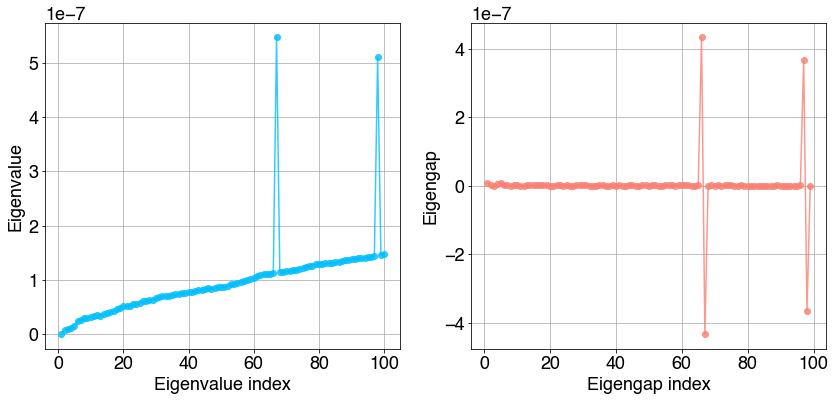

65

In [43]:
vals_plot = vals[:100]

plt.figure(figsize=(14,6))
plt.subplot(121)
plt.plot((np.arange(len(vals_plot)) + 1), vals_plot, '-o', c='deepskyblue', alpha=0.8)
plt.grid()
plt.xlabel('Eigenvalue index')
plt.ylabel('Eigenvalue')

plt.subplot(122)
plt.plot((np.arange(len(vals_plot)) + 1)[:-1], np.diff(vals_plot), '-o', c='salmon', alpha=0.8)
plt.grid()
plt.xlabel('Eigengap index')
plt.ylabel('Eigengap')
plt.show()

# # automatically detect no_clusters from eigengap
no_clust = np.where(abs(np.diff(vals_plot)) == (np.max(abs(np.diff(vals_plot)))))[0][0]
no_clust

---
## This appears to work but doesn't always converge
I think this is due to parameter choices but it's hard to say. Theres also an error in the eigengap, it should be somewhere in the range of 

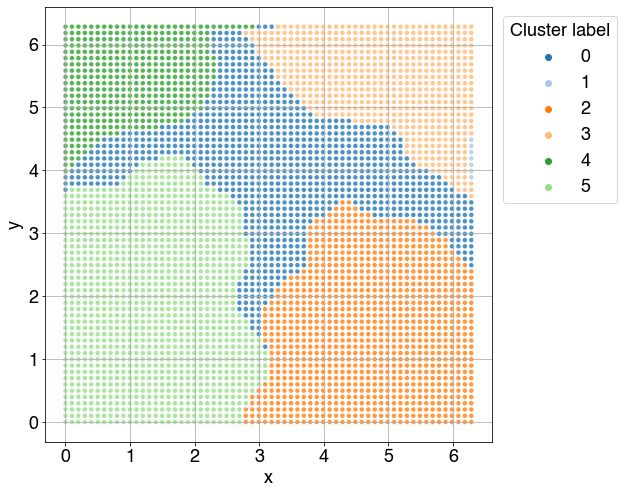

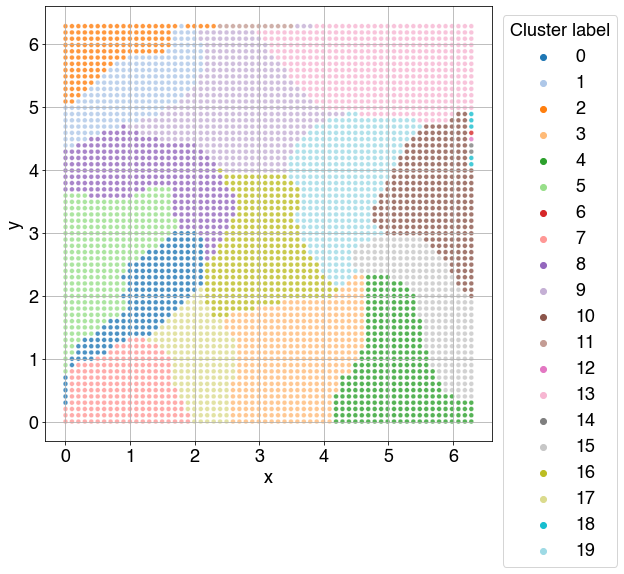

In [41]:
from sklearn.cluster import KMeans

point_size = 23

# # Run k means on normalized laplacian eigenvectors
# result = KMeans(no_clust+1,
#                max_iter = 10000,
#                init='random').fit(vecs[:,:no_clust+1])

# # plot initial position with labels
# plt.figure(figsize=(10,10))
# sns.scatterplot(x=x_pos[0].flatten(),
#                 y=y_pos[0].flatten(),
#                 hue=result.labels_,
#                 palette = 'tab20')

# plt.legend(title='Cluster label', bbox_to_anchor=(1.005,1))
# plt.xlabel('x')
# plt.ylabel('y')
# plt.grid()
# plt.show()

# Run k means on normalized laplacian eigenvectors
result = KMeans(no_clust+2,
               max_iter = 10000,
               init='random').fit(vecs[:,:(no_clust+1)])

# plot initial position with labels
plt.figure(figsize=(8,8))
sns.scatterplot(x=x_pos[0].flatten(),
                y=y_pos[0].flatten(),
                hue=result.labels_,
                palette = 'tab20',
                alpha=0.8,
                s = point_size)

plt.legend(title='Cluster label', bbox_to_anchor=(1.005,1))
plt.xlabel('x')
plt.ylabel('y')
plt.grid()
plt.show()


# Run k means on normalized laplacian eigenvectors
result = KMeans(20,
               max_iter = 10000,
               init='random').fit(vecs[:,:19])

# plot initial position with labels
plt.figure(figsize=(8,8))
sns.scatterplot(x=x_pos[0].flatten(),
                y=y_pos[0].flatten(),
                hue=result.labels_,
                palette = 'tab20',
                alpha=0.8,
                s = point_size)

plt.legend(title='Cluster label', bbox_to_anchor=(1.005,1))
plt.xlabel('x')
plt.ylabel('y')
plt.grid()
plt.show()